# Lesson 4: Morphological Operations

You now know how to find objects of interest in an image and produce masks which correspond to these objects. Up until now, we've relied on good image preprocessing to produce quality masks. Now we will talk about morphological operations, which instead focus on making improvements to the masks directly.

In this module you will learn
- What is a morphological operation
- How to choose the right parameters for your morphological operation
- Some common morphological operations
    - Erosion
    - Dilation
    - Opening
    - Closing
- How to perform various morphological operations in series
- What other morphological functions exist in the Scikit Image package
- To be mindful of the effect of successive morphological operations on the information content of your images

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('dark') # make plots look good

Let's pull up a mask we're familiar with

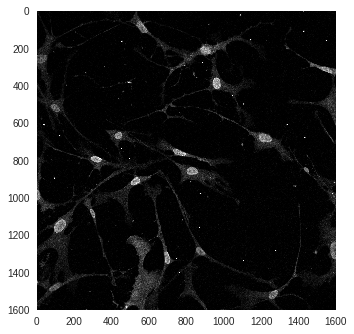

In [2]:
from skimage.io import imread

data = imread("../data/cells2d.tif")
img = data[:,:,2]
plt.imshow(img, cmap='gray')

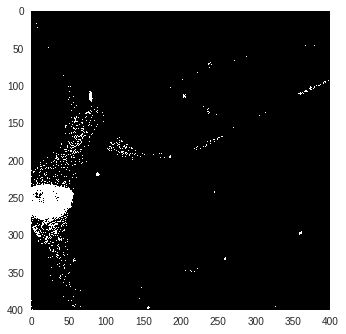

In [4]:
from skimage.filters import threshold_otsu

mask = img > threshold_otsu(img)
plt.imshow(mask[:400,:400], cmap='gray')

Notice how the edges are fuzzy. In some cases, a few pixels are missing from the middle of an object, leaving a hole. In other cases, isolated pixels in the mask might be identified by later processing as individual objects, cells, etc. This mask needs to be cleaned!

There are two very simple approaches we'll start with. One is called _erosion_, where pixels at the edge of the mask are eroded away. It's counterpart is _dilation_, where pixels at the edge grow outward. These algorithms can be implemented by going pixel-by-pixel and making changes to that pixel's local neighborhood.

The basic _morphological operations_ require two things to work: a mask and a structuring element. For each pixel, the structuring element is applied to the local neighborhood. Let's look at an example.

Imagine zooming way into the edge of a mask, and consider how a structuring element might be applied to a single pixel in a dilate operation.

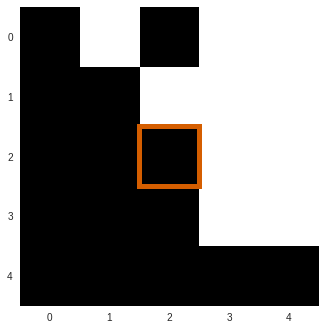

In [5]:
small_mask = np.array([[1, 0, 1, 0, 0],
                       [1, 1, 0, 0, 0],
                       [1, 1, 1, 0, 0],
                       [1, 1, 1, 0, 0],
                       [1, 1, 1, 1, 1]])
plt.gca().add_patch(plt.Rectangle((1.5, 1.5), 1, 1, fill=None, color='r', lw=5))
plt.imshow(small_mask, interpolation='nearest')

Let's observe what happens if we dilate with the structuring element below.

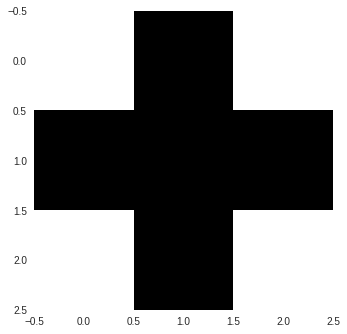

In [6]:
selem = np.array([[0, 1, 0],
                  [1, 1, 1],
                  [0, 1, 0]])
plt.imshow(selem, interpolation='nearest')

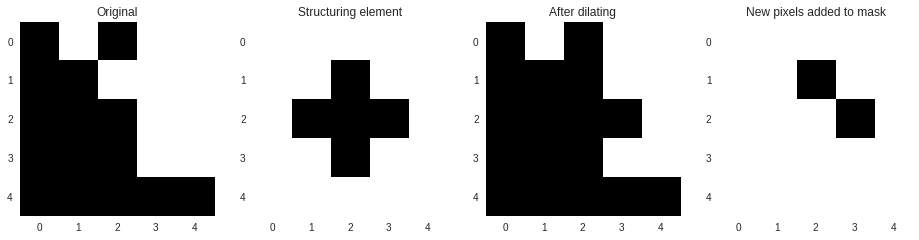

In [10]:
padded_selem = np.pad(selem, 1, 'constant')
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(small_mask, interpolation='nearest')
ax[0].set_title("Original")
ax[1].imshow(padded_selem, interpolation='nearest')
ax[1].set_title("Structuring element")
ax[2].imshow(small_mask | padded_selem, interpolation='nearest')
ax[2].set_title("After dilating")
ax[3].imshow(small_mask < padded_selem, interpolation='nearest')
ax[3].set_title("New pixels added to mask")

We would then continue to apply the dilation to every pixel in the mask, causing its borders to grow. `skimage` has a function for that.

In [11]:
from skimage.morphology import binary_dilation

`scikit-image` calls this "binary" because masks are either 1 (in the mask) or 0 (not in the mask). There is also general erosion, which propagates pixel values instead of 1s and 0s. It would be applied to images rather than masks, and is generally less useful.

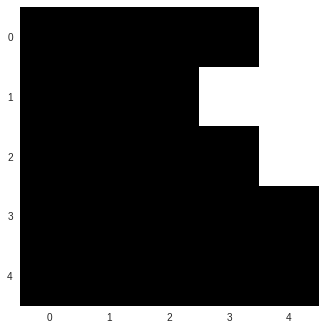

In [12]:
plt.imshow(binary_dilation(small_mask, selem), interpolation='nearest')

We can make the growth more dramatic by expanding the structuring element.

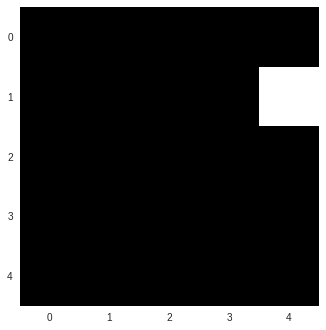

In [13]:
big_selem = np.array([[0, 0, 1, 0, 0],
                      [0, 0, 1, 0, 0],
                      [1, 1, 1, 1, 1],
                      [0, 0, 1, 0, 0],
                      [0, 0, 1, 0, 0]])
plt.imshow(binary_dilation(small_mask, big_selem), interpolation='nearest')

You have total freedom to choose any structuring element you want, but generally simple symmetric shapes are used because their effects are intuitive. In fact, we can let `scikit-image` generate reasonable structuring elements for us! This is a good idea to maximize repeatability.

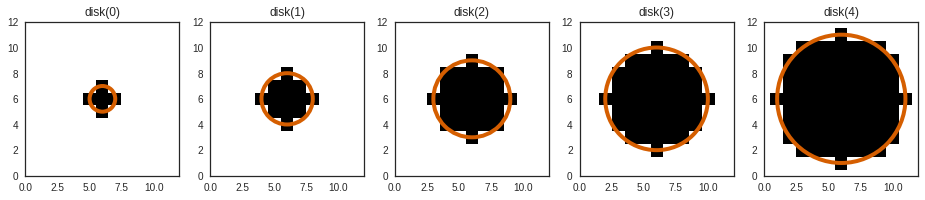

In [14]:
from skimage.morphology import disk

with sns.axes_style('white'):
    N = 5
    fig, axes = plt.subplots(1, N, figsize=(16, 3))
    for n, ax in enumerate(axes):
        np1 = n + 1
        ax.imshow(np.pad(disk(np1), N-n, 'constant'), interpolation='nearest')
        c = plt.Circle((np1 + N - n, np1 + N - n), radius=np1, fill=False, lw=4, color='r')
        ax.add_artist(c)
        ax.set_xlim(0, 2 * N + 2)
        ax.set_ylim(0, 2 * N + 2)
        ax.set_title("disk({})".format(n))

Here we demonstrate `disk` with different radius parameters. The circles of corresponding radius are superimposed.

**Exercise** Perform a binary _erosion_ of `small_mask` with a radius=1 `disk`. Can you guess what the function for erosion will be called?

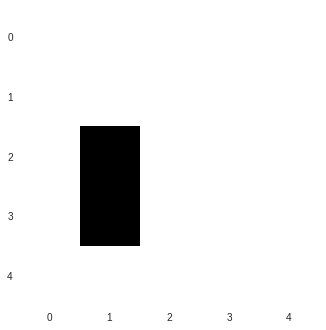

In [15]:
from skimage.morphology import binary_erosion

eroded_mask = binary_erosion(small_mask, disk(1))
plt.imshow(eroded_mask, interpolation='nearest')

This kind of thing can be very useful if you know the physical size of your pixels. For example, if you have $10\mu m$-diameter cells and your pixels are $1\mu m^2$, then eroding with `disk(4)` should remove any mask too small to be a cell!

In general, morphological operations work best when the shape of the structuring element matches the shape of features you want to retain or remove. Let's look at an exmaple.

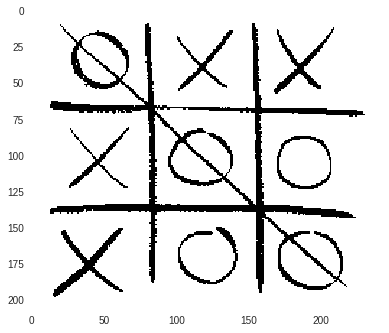

In [16]:
from skimage.color import rgb2gray

tictac_original = 1 - rgb2gray(imread('../data/tic_tac_toe.jpeg'))
tictac = tictac_original > threshold_otsu(tictac_original)
plt.imshow(tictac)

Can you guess what happens when we erode with the following filter?

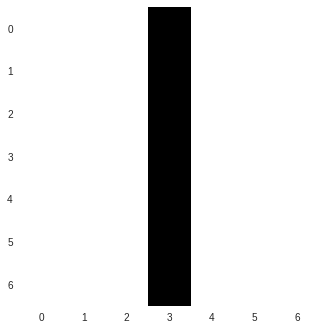

In [17]:
vline = np.zeros((7,7))
vline[:,3] = 1
plt.imshow(vline, interpolation='nearest')

Let's find out.

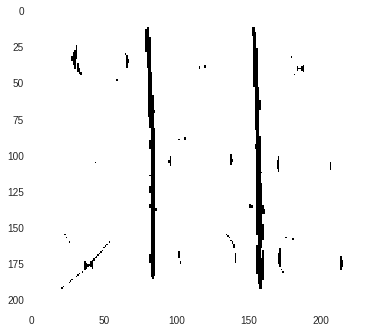

In [18]:
plt.imshow(binary_erosion(tictac, vline))

Eroding with a vertical line caused vertical segments to be preserved! So imagine if you have something like 96 well plate which is also composed of vertical lines, horizontal lines, and circles, and you wanted to find where the rows were, this sort of thing might be helpful.

**Exercise** What will happen if we apply dilation with a vertical line?

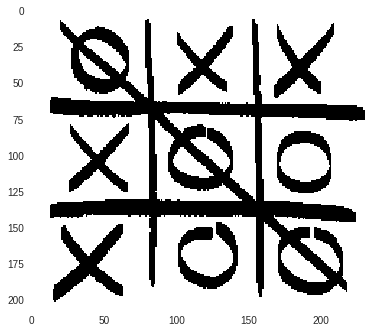

In [19]:
plt.imshow(binary_dilation(tictac, vline))

Let's return to our original image mask and apply a dilation to fill in holes in cells.

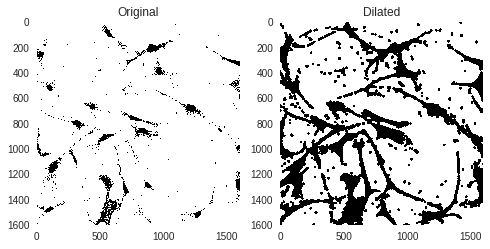

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(mask)
ax[0].set_title("Original")
ax[1].imshow(binary_dilation(mask, disk(10)))
ax[1].set_title("Dilated")

That certainly filled in a lot of the holes. However it also expanded all of the small specks that we're not interested in. This hints at a more troubling problem with dilation: it always grows the mask; erosion always shrinks it. These are _biasing_ operations!

To correct this, a common approach is to apply an erosion after a dilation or a dilation after an erosion.

Contrary to your intuition, these don't negate each other. Consider a mask consisting of a single isolated pixel. After an erosion, it vanishes. A subsequent dilation does nothing, because no pixels belong to the mask.

**Exercise** Show what happens to holes in your mask if you dilate and then erode?

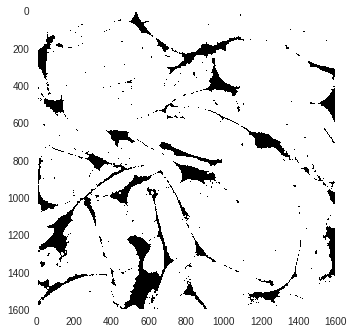

In [24]:
dilated = binary_dilation(mask, disk(5))
eroded = binary_erosion(dilated, disk(5))
plt.imshow(eroded)

Holes remain closed, and edges are smoothed somewhat. This effect is so important that dilating then eroding is called _closing_ since it closes holes.

- dilate + erose -> "closing"
- erode + dilate -> "opening"

In [25]:
from skimage.morphology import binary_closing, binary_opening

Note that we haven't solved our small speck problem with closing. So now let's do something really useful here. We will first close to fill holes, then open to remove specks.

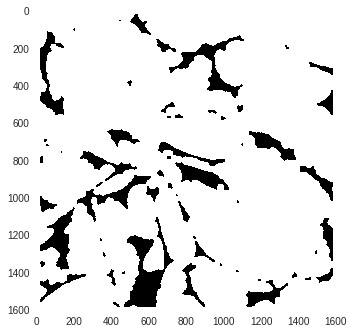

In [26]:
first_stage = binary_closing(mask, disk(15))
second_stage = binary_opening(first_stage, disk(5))
plt.imshow(second_stage)

Remember that the more morphological operations you do, the farther away you get from the original image - you're slowly destroying information. Recall that closing works because erosion doesn't recover the origiinal image after a dilation. This is a general concept in computing known as the information processing inequality: each step in a series of processing steps either decreases the amount of information or leaves it the same; if this weren't true you could process an image more and more and never have to make a new measurement. We're OK with this, because we can use image processing to _extract_ information we want, removing information we don't.

There are other morphological image processing tools as well. You can search for them in the `scikit` docs, or peak into the library programatically.

In [32]:
import skimage.morphology
print('\n'.join(skimage.morphology.__all__))

binary_erosion
binary_dilation
binary_opening
binary_closing
erosion
dilation
opening
closing
white_tophat
black_tophat
square
rectangle
diamond
disk
cube
octahedron
ball
octagon
label
watershed
skeletonize
skeletonize_3d
medial_axis
convex_hull_image
convex_hull_object
reconstruction
remove_small_objects
remove_small_holes


A final note on exploring libraries: developers building a Python library will specify an `__all__` variable, which tells applications using the library which functions they are supposed to see so that other utility functions can be defined behind the scenes in secret. We exploited the existance of the `__all__` variable here.